In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
from utils import *
import pandas as pd
import numpy as np
import warnings
import dal
warnings.filterwarnings("ignore")

snow_runner = dal.SnowflakeRunner()

In [3]:
dict_cursor = snow_runner.get_data_raw('queries/conversations_public.sql')
dict_cursor_roles = snow_runner.get_data_raw('queries/user_roles.sql')
df = pd.DataFrame(dict_cursor)
df['users_per_project'] = df.groupby(['PROJECT_ID'])['USER_ID'].transform('nunique')
df['users_per_project_quantile'] = pd.qcut(df['users_per_project'], 3, labels=False)

In [4]:
project_users_cursor = snow_runner.get_data_raw('queries/project_to_staff.sql')
df_project_users = pd.DataFrame(project_users_cursor)

In [5]:
projects = list(set(df.PROJECT_ID))
list_net = []
for project in  projects:
    user_list = list(set(df[df.PROJECT_ID == project].USER_ID))
    data = list(filter(lambda x: x['PROJECT_ID'] == project, dict_cursor))
    roles = list(filter(lambda x: x['USER_ID'] in user_list, dict_cursor_roles))
    list_net.append({'project_id':project, 'network': build_network(data, roles)})

In [8]:
project_centrality = []
for project in projects:
    network = [i for i in filter(lambda x: x['project_id'] == project, list_net)][0]['network']
    centrality_dict = nx.eigenvector_centrality(network, weight='weight', max_iter=1000)
    centrality_list = [{key:value} for key, value in centrality_dict.items()]
    for i in centrality_list:
        for user, centrality_ in i.items():
            
            project_centrality.append({'project_id': project, 'user_id': user, 'centrality': centrality_})

In [9]:
df_user_centrality = pd.DataFrame(project_centrality)
df_project_users_filtered = df_project_users[df_project_users.PROJECT_ID.isin(projects)]

In [10]:
df_centrality = df_project_users_filtered.merge(df_user_centrality, right_on=['project_id', 'user_id'], left_on=['PROJECT_ID', 'USER_ID'], how = 'left')
df_centrality= df_centrality[pd.notnull(df_centrality.project_id)]
df_centrality = df_centrality[['PROJECT_ID', 'USER_ID', 'centrality','MAPPING_TYPE']].fillna(0)
df_centrality_cpms = df_centrality[df_centrality.MAPPING_TYPE == 'CPM']

In [11]:
project_on_time_cursor = snow_runner.get_data_raw('queries/project_on_time.sql')
df_project_on_time = pd.DataFrame(project_on_time_cursor)

In [12]:

df_cpms_full = df_centrality_cpms.merge(df_project_on_time, how = 'left', right_on='PROJECT_ID', left_on='PROJECT_ID')
df_cpms_full_filtered = df_cpms_full[pd.notnull(df_cpms_full.IS_ONTIME)]

In [13]:
df_final = df_cpms_full_filtered.groupby('USER_ID').agg({'PROJECT_ID':'nunique', 'IS_ONTIME':'sum', 'centrality':'mean'})

In [14]:
df_final['pct_project_ot'] = df_final.IS_ONTIME/df_final.PROJECT_ID
df_final['pct_project_not'] = 1 - df_final.pct_project_ot
df_final['entropy'] = - ((df_final.pct_project_ot*np.log(df_final.pct_project_ot)) + (df_final.pct_project_not*np.log(df_final.pct_project_not)))

In [15]:
df_final['log_projects'] = np.log(df_final.PROJECT_ID)
df_final['log_pct_project_ot'] = np.log(df_final.pct_project_ot)
df_final['log_pct_project_ot'].replace(-np.inf,np.NAN, inplace=True)

In [16]:
mean_cantrality = df_final.centrality.mean()
var_cantrality = np.var(df_final.centrality)

mean_entropy = df_final.entropy.mean()
var_entropy = np.var(df_final.entropy) 

mean_pct_project_ot = df_final.pct_project_ot.mean()
var_pct_project_ot = np.var(df_final.pct_project_ot)

In [17]:
#df_final['normalised_centrality'] = df_final['centrality'].apply(lambda x:normalise(mean_cantrality, var_cantrality, x) )
#df_final['normalised_entropy'] = df_final['entropy'].apply(lambda x:normalise(mean_entropy, var_entropy, x) )
#df_final['normalised_pot'] = df_final['pct_project_ot'].apply(lambda x:normalise(mean_pct_project_ot, var_pct_project_ot, x) )

In [18]:
df_final = df_final[(df_final.PROJECT_ID > 10) & (df_final.IS_ONTIME > 0)]

In [19]:
df_final.fillna(1, inplace=True)

In [20]:
df_final[['centrality', 'entropy']].corr()

,centrality,entropy
centrality,1.000000,0.017512
entropy,0.017512,1.000000


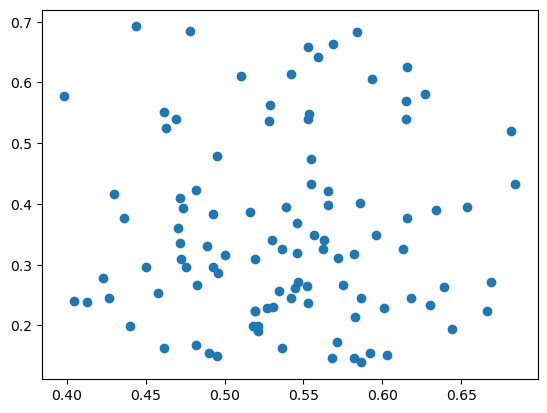

In [21]:
plt.scatter(df_final.centrality, df_final.entropy)

In [22]:
df_final[df_final.centrality > .06].log_pct_project_ot.mean()
df_final[df_final.centrality < .06].log_pct_project_ot.mean()

nan

<AxesSubplot: >

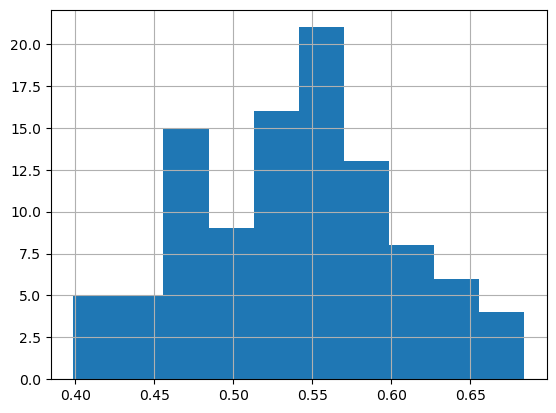

In [23]:
df_final.centrality.hist(bins = 10)

<AxesSubplot: >

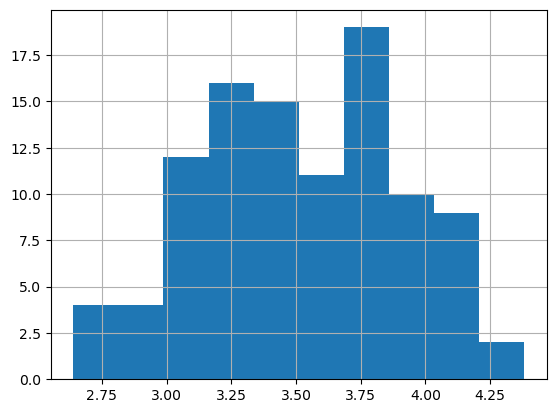

In [24]:
df_final.log_projects.hist(bins = 10)

<AxesSubplot: >

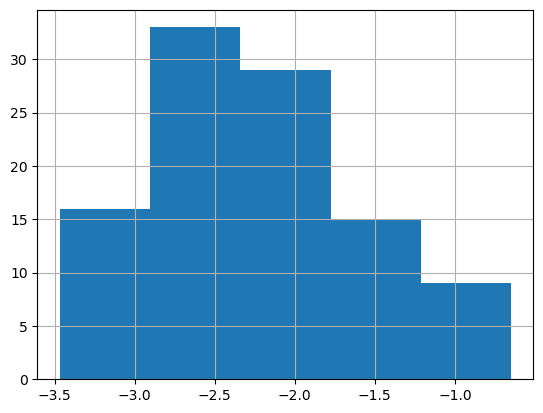

In [25]:
df_final.log_pct_project_ot.hist(bins = 5)

In [26]:
n1 = len(df_final[df_final.centrality > 0.55])
n2 = len(df_final[(df_final.centrality < 0.55) ])
s1 = np.var(df_final[df_final.centrality > 0.55].log_pct_project_ot)
s2 = np.var(df_final[(df_final.centrality < 0.55) ].log_pct_project_ot)
m1 = df_final[df_final.centrality > 0.55].log_pct_project_ot.mean()
m2 = df_final[(df_final.centrality < 0.55) ].log_pct_project_ot.mean()
significance(n1, n2, s1, s2, m1, m2)

The difference is NOT significant


0.7517447299671959

In [27]:
s1 = np.var(df_final[df_final.centrality > 0.55].log_projects)
s2 = np.var(df_final[(df_final.centrality < 0.55) ].log_projects)
m1 = df_final[df_final.centrality > 0.55].log_projects.mean()
m2 = df_final[(df_final.centrality < 0.55) ].log_projects.mean()

significance(n1, n2, s1, s2, m1, m2)

The difference is NOT significant


-1.0056069555968203